In [67]:
import gymnasium as gym
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from cellitaire.environment.cellitaire_env import CellitaireEnv

In [68]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches
        
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        self.actions.append(action)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

In [69]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo', num_embeddings=53, embedding_dim=30, embeddings_in_state=85):
        super(ActorNetwork, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim).to(self.device)
        self.embeddings_in_state = embeddings_in_state
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(input_dims[0] - self.embeddings_in_state + (self.embeddings_in_state * embedding_dim), fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)
        
        self.n_actions = n_actions

    def forward(self, state):
        embeddings = self.embedding_layer(state[:, :self.embeddings_in_state].int()).view(state.shape[0], 1, -1)
        state = state.view(state.shape[0], 1, -1)[:, :, self.embeddings_in_state:]
        state = torch.concatenate((state, embeddings), dim=2)
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist
    
    '''
    def forward_with_mask(self, state, legal_actions):
        embeddings = self.embedding_layer(state[:, :self.embeddings_in_state].int()).view(state.shape[0], 1, -1)
        state = state.view(state.shape[0], 1, -1)[:, :, self.embeddings_in_state:]
        state = torch.concatenate((state, embeddings), dim=2)
        dist = self.actor(state)
        legal_actions_mask = torch.full((state.shape[0], 1, self.n_actions), -1e9)
        for action in legal_actions:
            legal_actions_mask[0, 0, action] = 1
        print(legal_actions_mask.shape)
        print(dist.shape)
        dist = dist * legal_actions_mask
        dist = Categorical(dist)
        
        return dist
    '''

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [70]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [73]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.n_actions = n_actions

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = torch.tensor([observation], dtype=torch.float).to(self.actor.device)
        
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = torch.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = torch.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()               

In [74]:
env = CellitaireEnv(None)

In [ ]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, input_dims=(7 * 12 + 6,), batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)

n_games = 15000

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation, reward, done, info = env.reset()
    done = False
    score = 0
    while not done:
        #legal_actions = env.get_legal_actions_as_int()
        #print(legal_actions)
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score,'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)

... saving models ...
episode 0 score -289.0 avg score -289.0 time_steps 313 learning_steps 15
... saving models ...
episode 1 score -267.0 avg score -278.0 time_steps 648 learning_steps 32
episode 2 score -280.0 avg score -278.7 time_steps 970 learning_steps 48
episode 3 score -286.0 avg score -280.5 time_steps 1286 learning_steps 64
episode 4 score -285.0 avg score -281.4 time_steps 1603 learning_steps 80
episode 5 score -291.0 avg score -283.0 time_steps 1914 learning_steps 95
episode 6 score -283.0 avg score -283.0 time_steps 2233 learning_steps 111
... saving models ...
episode 7 score -200.0 avg score -272.6 time_steps 2461 learning_steps 123
episode 8 score -296.0 avg score -275.2 time_steps 2767 learning_steps 138
episode 9 score -260.0 avg score -273.7 time_steps 3041 learning_steps 152
episode 10 score -281.0 avg score -274.4 time_steps 3362 learning_steps 168
... saving models ...
episode 11 score -240.0 avg score -271.5 time_steps 3644 learning_steps 182
episode 12 score -2

... saving models ...
episode 101 score -133.0 avg score -206.7 time_steps 24023 learning_steps 1201
... saving models ...
episode 102 score -19.0 avg score -204.1 time_steps 24058 learning_steps 1202
... saving models ...
episode 103 score -84.0 avg score -202.1 time_steps 24162 learning_steps 1208
... saving models ...
episode 104 score -67.0 avg score -199.9 time_steps 24251 learning_steps 1212
... saving models ...
episode 105 score -29.0 avg score -197.3 time_steps 24292 learning_steps 1214
... saving models ...
episode 106 score -103.0 avg score -195.5 time_steps 24411 learning_steps 1220
... saving models ...
episode 107 score -34.0 avg score -193.8 time_steps 24457 learning_steps 1222
... saving models ...
episode 108 score -15.0 avg score -191.0 time_steps 24484 learning_steps 1224
... saving models ...
episode 109 score -26.0 avg score -188.7 time_steps 24522 learning_steps 1226
... saving models ...
episode 110 score -3.0 avg score -185.9 time_steps 24537 learning_steps 1226

episode 190 score -98.0 avg score -115.1 time_steps 36373 learning_steps 1818
episode 191 score -280.0 avg score -117.4 time_steps 36695 learning_steps 1834
episode 192 score -6.0 avg score -117.0 time_steps 36713 learning_steps 1835
episode 193 score -292.0 avg score -119.7 time_steps 37023 learning_steps 1851
episode 194 score -46.0 avg score -120.1 time_steps 37085 learning_steps 1854
episode 195 score -22.0 avg score -119.5 time_steps 37123 learning_steps 1856
episode 196 score -290.0 avg score -122.0 time_steps 37435 learning_steps 1871
episode 197 score -173.0 avg score -121.3 time_steps 37624 learning_steps 1881
episode 198 score -35.0 avg score -120.1 time_steps 37677 learning_steps 1883
episode 199 score -153.0 avg score -119.9 time_steps 37874 learning_steps 1893
episode 200 score -291.0 avg score -119.9 time_steps 38185 learning_steps 1909
episode 201 score -6.0 avg score -118.6 time_steps 38203 learning_steps 1910
episode 202 score -36.0 avg score -118.8 time_steps 38251 le

... saving models ...
episode 290 score -16.0 avg score -85.1 time_steps 46727 learning_steps 2336
... saving models ...
episode 291 score -56.0 avg score -82.8 time_steps 46799 learning_steps 2339
episode 292 score -285.0 avg score -85.6 time_steps 47116 learning_steps 2355
episode 293 score -19.0 avg score -82.9 time_steps 47149 learning_steps 2357
episode 294 score -50.0 avg score -82.9 time_steps 47223 learning_steps 2361
episode 295 score -223.0 avg score -85.0 time_steps 47490 learning_steps 2374
... saving models ...
episode 296 score -57.0 avg score -82.6 time_steps 47575 learning_steps 2378
episode 297 score -297.0 avg score -83.9 time_steps 47880 learning_steps 2394
episode 298 score -38.0 avg score -83.9 time_steps 47934 learning_steps 2396
... saving models ...
episode 299 score -6.0 avg score -82.4 time_steps 47952 learning_steps 2397
... saving models ...
episode 300 score -9.0 avg score -79.6 time_steps 47973 learning_steps 2398
episode 301 score -48.0 avg score -80.0 ti

episode 388 score -297.0 avg score -61.8 time_steps 54327 learning_steps 2716
episode 389 score -16.0 avg score -61.8 time_steps 54355 learning_steps 2717
episode 390 score -27.0 avg score -61.9 time_steps 54394 learning_steps 2719
episode 391 score -31.0 avg score -61.6 time_steps 54437 learning_steps 2721
episode 392 score -93.0 avg score -59.7 time_steps 54546 learning_steps 2727
episode 393 score -16.0 avg score -59.7 time_steps 54574 learning_steps 2728
episode 394 score -18.0 avg score -59.4 time_steps 54604 learning_steps 2730
episode 395 score -46.0 avg score -57.6 time_steps 54662 learning_steps 2733
episode 396 score -5.0 avg score -57.1 time_steps 54679 learning_steps 2733
... saving models ...
episode 397 score -154.0 avg score -55.6 time_steps 54851 learning_steps 2742
episode 398 score -45.0 avg score -55.7 time_steps 54908 learning_steps 2745
episode 399 score -26.0 avg score -55.9 time_steps 54946 learning_steps 2747
episode 400 score -20.0 avg score -56.0 time_steps 54

... saving models ...
episode 489 score -5.0 avg score -31.7 time_steps 58747 learning_steps 2937
... saving models ...
episode 490 score -5.0 avg score -31.4 time_steps 58764 learning_steps 2938
... saving models ...
episode 491 score -2.0 avg score -31.1 time_steps 58778 learning_steps 2938
... saving models ...
episode 492 score 0.0 avg score -30.2 time_steps 58790 learning_steps 2939
... saving models ...
episode 493 score -15.0 avg score -30.2 time_steps 58817 learning_steps 2940
... saving models ...
episode 494 score 0.0 avg score -30.0 time_steps 58829 learning_steps 2941
... saving models ...
episode 495 score -11.0 avg score -29.7 time_steps 58852 learning_steps 2942
episode 496 score -9.0 avg score -29.7 time_steps 58873 learning_steps 2943
... saving models ...
episode 497 score -9.0 avg score -28.3 time_steps 58894 learning_steps 2944
... saving models ...
episode 498 score -22.0 avg score -28.0 time_steps 58928 learning_steps 2946
... saving models ...
episode 499 score -

episode 589 score -297.0 avg score -22.8 time_steps 62230 learning_steps 3111
episode 590 score -7.0 avg score -22.9 time_steps 62249 learning_steps 3112
episode 591 score -25.0 avg score -23.1 time_steps 62286 learning_steps 3114
episode 592 score -25.0 avg score -23.3 time_steps 62323 learning_steps 3116
episode 593 score -29.0 avg score -23.5 time_steps 62364 learning_steps 3118
episode 594 score -24.0 avg score -23.7 time_steps 62400 learning_steps 3120
episode 595 score -7.0 avg score -23.7 time_steps 62419 learning_steps 3120
episode 596 score -6.0 avg score -23.6 time_steps 62437 learning_steps 3121
episode 597 score -9.0 avg score -23.6 time_steps 62458 learning_steps 3122
episode 598 score -23.0 avg score -23.6 time_steps 62493 learning_steps 3124
episode 599 score -6.0 avg score -23.7 time_steps 62511 learning_steps 3125
episode 600 score -31.0 avg score -23.9 time_steps 62554 learning_steps 3127
episode 601 score -11.0 avg score -23.8 time_steps 62577 learning_steps 3128
epi

episode 696 score -1.0 avg score -19.1 time_steps 65560 learning_steps 3278
episode 697 score -111.0 avg score -20.1 time_steps 65683 learning_steps 3284
episode 698 score -2.0 avg score -19.9 time_steps 65697 learning_steps 3284
episode 699 score -289.0 avg score -22.7 time_steps 66010 learning_steps 3300
episode 700 score -250.0 avg score -24.9 time_steps 66272 learning_steps 3313
episode 701 score -9.0 avg score -24.9 time_steps 66293 learning_steps 3314
episode 702 score -12.0 avg score -24.9 time_steps 66317 learning_steps 3315
episode 703 score -20.0 avg score -24.3 time_steps 66349 learning_steps 3317
episode 704 score -36.0 avg score -24.6 time_steps 66397 learning_steps 3319
episode 705 score -4.0 avg score -24.5 time_steps 66413 learning_steps 3320
episode 706 score -3.0 avg score -24.3 time_steps 66428 learning_steps 3321
episode 707 score -105.0 avg score -25.4 time_steps 66545 learning_steps 3327
episode 708 score -5.0 avg score -25.2 time_steps 66562 learning_steps 3328
e

episode 804 score -297.0 avg score -49.5 time_steps 72574 learning_steps 3628
episode 805 score 0.0 avg score -49.5 time_steps 72586 learning_steps 3629
episode 806 score -7.0 avg score -49.5 time_steps 72605 learning_steps 3630
episode 807 score -297.0 avg score -51.5 time_steps 72910 learning_steps 3645
episode 808 score -41.0 avg score -51.8 time_steps 72967 learning_steps 3648
episode 809 score -295.0 avg score -54.5 time_steps 73274 learning_steps 3663
episode 810 score -13.0 avg score -54.5 time_steps 73299 learning_steps 3664
episode 811 score -66.0 avg score -54.6 time_steps 73377 learning_steps 3668
episode 812 score -23.0 avg score -54.7 time_steps 73412 learning_steps 3670
episode 813 score -155.0 avg score -53.3 time_steps 73583 learning_steps 3679
episode 814 score -6.0 avg score -52.0 time_steps 73601 learning_steps 3680
episode 815 score -5.0 avg score -49.7 time_steps 73618 learning_steps 3680
episode 816 score -123.0 avg score -50.9 time_steps 73757 learning_steps 3687

episode 911 score -38.0 avg score -40.5 time_steps 78845 learning_steps 3942
episode 912 score -25.0 avg score -40.5 time_steps 78882 learning_steps 3944
episode 913 score -23.0 avg score -39.2 time_steps 78921 learning_steps 3946
episode 914 score -17.0 avg score -39.3 time_steps 78954 learning_steps 3947
episode 915 score -18.0 avg score -39.4 time_steps 78984 learning_steps 3949
episode 916 score -4.0 avg score -38.2 time_steps 79000 learning_steps 3950
episode 917 score -14.0 avg score -38.4 time_steps 79026 learning_steps 3951
episode 918 score -12.0 avg score -37.1 time_steps 79050 learning_steps 3952
episode 919 score -26.0 avg score -37.3 time_steps 79092 learning_steps 3954
episode 920 score -28.0 avg score -36.9 time_steps 79132 learning_steps 3956
episode 921 score -11.0 avg score -35.4 time_steps 79155 learning_steps 3957
episode 922 score -39.0 avg score -34.9 time_steps 79210 learning_steps 3960
episode 923 score -63.0 avg score -35.4 time_steps 79301 learning_steps 3965


episode 1018 score -38.0 avg score -35.3 time_steps 84279 learning_steps 4213
episode 1019 score -20.0 avg score -35.2 time_steps 84315 learning_steps 4215
episode 1020 score -48.0 avg score -35.4 time_steps 84389 learning_steps 4219
episode 1021 score -7.0 avg score -35.4 time_steps 84412 learning_steps 4220
episode 1022 score -5.0 avg score -35.0 time_steps 84435 learning_steps 4221
episode 1023 score -1.0 avg score -34.4 time_steps 84448 learning_steps 4222
episode 1024 score -17.0 avg score -34.4 time_steps 84477 learning_steps 4223
episode 1025 score -52.0 avg score -34.6 time_steps 84549 learning_steps 4227
episode 1026 score 0.0 avg score -34.5 time_steps 84565 learning_steps 4228
episode 1027 score -10.0 avg score -34.1 time_steps 84587 learning_steps 4229
episode 1028 score -4.0 avg score -33.7 time_steps 84603 learning_steps 4230
episode 1029 score -46.0 avg score -33.9 time_steps 84669 learning_steps 4233
episode 1030 score -10.0 avg score -33.4 time_steps 84691 learning_ste

episode 1125 score -50.0 avg score -24.4 time_steps 88499 learning_steps 4424
episode 1126 score -28.0 avg score -24.7 time_steps 88539 learning_steps 4426
episode 1127 score -14.0 avg score -24.7 time_steps 88565 learning_steps 4428
episode 1128 score -22.0 avg score -24.9 time_steps 88599 learning_steps 4429
episode 1129 score 1.0 avg score -24.4 time_steps 88610 learning_steps 4430
episode 1130 score -6.0 avg score -24.4 time_steps 88628 learning_steps 4431
episode 1131 score -9.0 avg score -24.3 time_steps 88649 learning_steps 4432
episode 1132 score -10.0 avg score -24.4 time_steps 88671 learning_steps 4433
episode 1133 score -19.0 avg score -24.2 time_steps 88702 learning_steps 4435
episode 1134 score 0.0 avg score -24.0 time_steps 88714 learning_steps 4435
episode 1135 score -10.0 avg score -24.0 time_steps 88736 learning_steps 4436
episode 1136 score -10.0 avg score -23.9 time_steps 88758 learning_steps 4437
episode 1137 score -62.0 avg score -21.6 time_steps 88850 learning_ste

episode 1231 score -17.0 avg score -24.3 time_steps 92542 learning_steps 4627
episode 1232 score -7.0 avg score -24.2 time_steps 92561 learning_steps 4628
episode 1233 score -1.0 avg score -24.1 time_steps 92574 learning_steps 4628
episode 1234 score -5.0 avg score -24.1 time_steps 92591 learning_steps 4629
episode 1235 score -4.0 avg score -24.1 time_steps 92611 learning_steps 4630
episode 1236 score -11.0 avg score -24.1 time_steps 92634 learning_steps 4631
episode 1237 score -9.0 avg score -23.5 time_steps 92655 learning_steps 4632
episode 1238 score -4.0 avg score -23.6 time_steps 92671 learning_steps 4633
episode 1239 score -14.0 avg score -23.6 time_steps 92705 learning_steps 4635
episode 1240 score -5.0 avg score -23.7 time_steps 92722 learning_steps 4636
episode 1241 score -66.0 avg score -24.3 time_steps 92810 learning_steps 4640
episode 1242 score 0.0 avg score -24.2 time_steps 92822 learning_steps 4641
episode 1243 score -19.0 avg score -24.3 time_steps 92853 learning_steps 

episode 1335 score -11.0 avg score -17.4 time_steps 95668 learning_steps 4783
episode 1336 score -4.0 avg score -17.3 time_steps 95684 learning_steps 4784
episode 1337 score -18.0 avg score -17.4 time_steps 95714 learning_steps 4785
episode 1338 score -1.0 avg score -17.4 time_steps 95727 learning_steps 4786
episode 1339 score -5.0 avg score -17.3 time_steps 95744 learning_steps 4787
episode 1340 score 2.0 avg score -17.2 time_steps 95754 learning_steps 4787
episode 1341 score -19.0 avg score -16.8 time_steps 95785 learning_steps 4789
episode 1342 score -5.0 avg score -16.8 time_steps 95802 learning_steps 4790
episode 1343 score 1.0 avg score -16.6 time_steps 95813 learning_steps 4790
episode 1344 score -51.0 avg score -17.0 time_steps 95880 learning_steps 4794
episode 1345 score -27.0 avg score -17.2 time_steps 95919 learning_steps 4795
episode 1346 score -37.0 avg score -17.0 time_steps 95968 learning_steps 4798
episode 1347 score -10.0 avg score -17.1 time_steps 95990 learning_steps

episode 1439 score -31.0 avg score -14.4 time_steps 98441 learning_steps 4922
episode 1440 score 1.0 avg score -14.4 time_steps 98452 learning_steps 4922
episode 1441 score -120.0 avg score -15.4 time_steps 98584 learning_steps 4929
episode 1442 score -6.0 avg score -15.4 time_steps 98602 learning_steps 4930
episode 1443 score -124.0 avg score -16.7 time_steps 98754 learning_steps 4937
episode 1444 score -46.0 avg score -16.6 time_steps 98812 learning_steps 4940
episode 1445 score -24.0 avg score -16.6 time_steps 98848 learning_steps 4942
episode 1446 score -71.0 avg score -16.9 time_steps 98953 learning_steps 4947
episode 1447 score -12.0 avg score -16.9 time_steps 98981 learning_steps 4949
episode 1448 score -15.0 avg score -17.0 time_steps 99008 learning_steps 4950
episode 1449 score -4.0 avg score -17.0 time_steps 99024 learning_steps 4951
episode 1450 score -10.0 avg score -16.9 time_steps 99054 learning_steps 4952
episode 1451 score -26.0 avg score -16.9 time_steps 99096 learning

episode 1544 score -44.0 avg score -14.8 time_steps 101631 learning_steps 5081
episode 1545 score -9.0 avg score -14.7 time_steps 101652 learning_steps 5082
episode 1546 score -15.0 avg score -14.1 time_steps 101679 learning_steps 5083
episode 1547 score -5.0 avg score -14.0 time_steps 101696 learning_steps 5084
... saving models ...
episode 1548 score -1.0 avg score -13.9 time_steps 101709 learning_steps 5085
episode 1549 score -37.0 avg score -14.2 time_steps 101762 learning_steps 5088
episode 1550 score -21.0 avg score -14.3 time_steps 101795 learning_steps 5089
episode 1551 score -9.0 avg score -14.2 time_steps 101816 learning_steps 5090
... saving models ...
episode 1552 score -21.0 avg score -13.6 time_steps 101849 learning_steps 5092
... saving models ...
episode 1553 score -8.0 avg score -13.5 time_steps 101869 learning_steps 5093
... saving models ...
episode 1554 score -7.0 avg score -13.3 time_steps 101888 learning_steps 5094
... saving models ...
episode 1555 score -1.0 avg

episode 1645 score -17.0 avg score -24.7 time_steps 105404 learning_steps 5270
episode 1646 score -7.0 avg score -24.6 time_steps 105423 learning_steps 5271
episode 1647 score -28.0 avg score -24.8 time_steps 105463 learning_steps 5273
episode 1648 score -96.0 avg score -25.8 time_steps 105585 learning_steps 5279
episode 1649 score -10.0 avg score -25.5 time_steps 105607 learning_steps 5280
episode 1650 score -39.0 avg score -25.7 time_steps 105662 learning_steps 5283
episode 1651 score -2.0 avg score -25.6 time_steps 105676 learning_steps 5283
episode 1652 score -15.0 avg score -25.6 time_steps 105707 learning_steps 5285
episode 1653 score -12.0 avg score -25.6 time_steps 105735 learning_steps 5286
episode 1654 score -4.0 avg score -25.6 time_steps 105751 learning_steps 5287
episode 1655 score -12.0 avg score -25.7 time_steps 105775 learning_steps 5288
episode 1656 score -20.0 avg score -25.9 time_steps 105807 learning_steps 5290
episode 1657 score -24.0 avg score -26.1 time_steps 105

episode 1751 score -22.0 avg score -21.3 time_steps 109041 learning_steps 5452
episode 1752 score -11.0 avg score -21.3 time_steps 109064 learning_steps 5453
episode 1753 score -36.0 avg score -21.5 time_steps 109112 learning_steps 5455
episode 1754 score -11.0 avg score -21.6 time_steps 109135 learning_steps 5456
episode 1755 score -52.0 avg score -22.0 time_steps 109203 learning_steps 5460
episode 1756 score -10.0 avg score -21.9 time_steps 109225 learning_steps 5461
episode 1757 score -4.0 avg score -21.7 time_steps 109241 learning_steps 5462
episode 1758 score -2.0 avg score -21.6 time_steps 109255 learning_steps 5462
episode 1759 score -57.0 avg score -22.1 time_steps 109328 learning_steps 5466
episode 1760 score -12.0 avg score -22.0 time_steps 109352 learning_steps 5467
episode 1761 score -14.0 avg score -22.0 time_steps 109378 learning_steps 5468
episode 1762 score -48.0 avg score -22.2 time_steps 109438 learning_steps 5471
episode 1763 score -22.0 avg score -22.1 time_steps 10

episode 1856 score -16.0 avg score -16.4 time_steps 112094 learning_steps 5604
episode 1857 score -7.0 avg score -16.4 time_steps 112113 learning_steps 5605
episode 1858 score -14.0 avg score -16.5 time_steps 112139 learning_steps 5606
episode 1859 score -1.0 avg score -16.0 time_steps 112152 learning_steps 5607
episode 1860 score -9.0 avg score -15.9 time_steps 112173 learning_steps 5608
episode 1861 score -3.0 avg score -15.8 time_steps 112188 learning_steps 5609
episode 1862 score -9.0 avg score -15.4 time_steps 112209 learning_steps 5610
episode 1863 score -10.0 avg score -15.3 time_steps 112231 learning_steps 5611
episode 1864 score -16.0 avg score -15.4 time_steps 112259 learning_steps 5612
episode 1865 score -26.0 avg score -15.6 time_steps 112297 learning_steps 5614
episode 1866 score -7.0 avg score -15.5 time_steps 112316 learning_steps 5615
episode 1867 score -3.0 avg score -15.5 time_steps 112331 learning_steps 5616
episode 1868 score -48.0 avg score -15.9 time_steps 112395 

episode 1962 score -16.0 avg score -13.9 time_steps 114822 learning_steps 5741
episode 1963 score -3.0 avg score -13.9 time_steps 114837 learning_steps 5741
episode 1964 score 0.0 avg score -13.7 time_steps 114849 learning_steps 5742
episode 1965 score -25.0 avg score -13.7 time_steps 114886 learning_steps 5744
episode 1966 score -15.0 avg score -13.8 time_steps 114913 learning_steps 5745
episode 1967 score -14.0 avg score -13.9 time_steps 114939 learning_steps 5746
episode 1968 score -12.0 avg score -13.5 time_steps 114963 learning_steps 5748
episode 1969 score -16.0 avg score -13.4 time_steps 114995 learning_steps 5749
episode 1970 score -15.0 avg score -13.6 time_steps 115022 learning_steps 5751
episode 1971 score 0.0 avg score -13.5 time_steps 115034 learning_steps 5751
episode 1972 score -5.0 avg score -13.5 time_steps 115051 learning_steps 5752
episode 1973 score -10.0 avg score -13.5 time_steps 115073 learning_steps 5753
episode 1974 score -15.0 avg score -13.0 time_steps 115100

episode 2064 score -12.0 avg score -11.1 time_steps 117173 learning_steps 5858
episode 2065 score -3.0 avg score -10.9 time_steps 117188 learning_steps 5859
episode 2066 score -4.0 avg score -10.8 time_steps 117204 learning_steps 5860
episode 2067 score -20.0 avg score -10.9 time_steps 117236 learning_steps 5861
episode 2068 score -253.0 avg score -13.3 time_steps 117505 learning_steps 5875
episode 2069 score -19.0 avg score -13.3 time_steps 117536 learning_steps 5876
episode 2070 score -22.0 avg score -13.4 time_steps 117570 learning_steps 5878
episode 2071 score -7.0 avg score -13.4 time_steps 117589 learning_steps 5879
episode 2072 score -18.0 avg score -13.6 time_steps 117619 learning_steps 5880
episode 2073 score -7.0 avg score -13.6 time_steps 117638 learning_steps 5881
episode 2074 score -59.0 avg score -14.0 time_steps 117709 learning_steps 5885
episode 2075 score -7.0 avg score -14.0 time_steps 117728 learning_steps 5886
episode 2076 score -4.0 avg score -14.0 time_steps 11774

episode 2170 score -46.0 avg score -34.7 time_steps 122352 learning_steps 6117
episode 2171 score -5.0 avg score -34.7 time_steps 122369 learning_steps 6118
episode 2172 score -3.0 avg score -34.6 time_steps 122384 learning_steps 6119
episode 2173 score 5.0 avg score -34.5 time_steps 122391 learning_steps 6119
episode 2174 score -289.0 avg score -36.8 time_steps 122704 learning_steps 6135
episode 2175 score -288.0 avg score -39.6 time_steps 123018 learning_steps 6150
episode 2176 score -10.0 avg score -39.6 time_steps 123040 learning_steps 6152
episode 2177 score -19.0 avg score -39.6 time_steps 123071 learning_steps 6153
episode 2178 score -13.0 avg score -39.6 time_steps 123096 learning_steps 6154
episode 2179 score -2.0 avg score -39.5 time_steps 123110 learning_steps 6155
episode 2180 score 1.0 avg score -39.4 time_steps 123121 learning_steps 6156
episode 2181 score -13.0 avg score -39.4 time_steps 123146 learning_steps 6157
episode 2182 score -294.0 avg score -42.0 time_steps 1234

episode 2276 score -4.0 avg score -25.9 time_steps 126860 learning_steps 6343
episode 2277 score -9.0 avg score -25.8 time_steps 126881 learning_steps 6344
episode 2278 score -3.0 avg score -25.7 time_steps 126896 learning_steps 6344
episode 2279 score -24.0 avg score -25.9 time_steps 126932 learning_steps 6346
episode 2280 score -28.0 avg score -26.2 time_steps 126972 learning_steps 6348
episode 2281 score -34.0 avg score -26.4 time_steps 127018 learning_steps 6350
episode 2282 score -1.0 avg score -23.4 time_steps 127031 learning_steps 6351
episode 2283 score -20.0 avg score -20.7 time_steps 127063 learning_steps 6353
episode 2284 score -21.0 avg score -20.6 time_steps 127096 learning_steps 6354
episode 2285 score -295.0 avg score -23.4 time_steps 127403 learning_steps 6370
episode 2286 score -9.0 avg score -23.5 time_steps 127424 learning_steps 6371
episode 2287 score -6.0 avg score -23.5 time_steps 127442 learning_steps 6372
episode 2288 score -1.0 avg score -23.4 time_steps 127455

episode 2382 score -10.0 avg score -24.0 time_steps 130664 learning_steps 6533
episode 2383 score -8.0 avg score -23.9 time_steps 130684 learning_steps 6534
episode 2384 score -10.0 avg score -23.8 time_steps 130706 learning_steps 6535
episode 2385 score -18.0 avg score -21.0 time_steps 130736 learning_steps 6536
episode 2386 score -6.0 avg score -21.0 time_steps 130754 learning_steps 6537
episode 2387 score -7.0 avg score -21.0 time_steps 130773 learning_steps 6538
episode 2388 score 0.0 avg score -21.0 time_steps 130785 learning_steps 6539
episode 2389 score -1.0 avg score -20.8 time_steps 130798 learning_steps 6539
episode 2390 score -12.0 avg score -20.9 time_steps 130822 learning_steps 6541
episode 2391 score -6.0 avg score -20.9 time_steps 130840 learning_steps 6542
episode 2392 score -291.0 avg score -23.8 time_steps 131151 learning_steps 6557
episode 2393 score -37.0 avg score -24.1 time_steps 131200 learning_steps 6560
episode 2394 score -1.0 avg score -24.1 time_steps 131213 

episode 2487 score -29.0 avg score -29.4 time_steps 134930 learning_steps 6746
episode 2488 score -10.0 avg score -29.5 time_steps 134952 learning_steps 6747
episode 2489 score -6.0 avg score -29.6 time_steps 134970 learning_steps 6748
episode 2490 score -20.0 avg score -29.6 time_steps 135004 learning_steps 6750
episode 2491 score -22.0 avg score -29.8 time_steps 135038 learning_steps 6751
episode 2492 score -1.0 avg score -26.9 time_steps 135051 learning_steps 6752
episode 2493 score -11.0 avg score -26.6 time_steps 135074 learning_steps 6753
episode 2494 score -7.0 avg score -26.7 time_steps 135093 learning_steps 6754
episode 2495 score -9.0 avg score -26.7 time_steps 135114 learning_steps 6755
episode 2496 score -25.0 avg score -27.0 time_steps 135151 learning_steps 6757
episode 2497 score -5.0 avg score -26.8 time_steps 135168 learning_steps 6758
episode 2498 score -5.0 avg score -26.9 time_steps 135185 learning_steps 6759
episode 2499 score -26.0 avg score -26.9 time_steps 135223

episode 2592 score -22.0 avg score -27.9 time_steps 139046 learning_steps 6952
episode 2593 score 0.0 avg score -27.8 time_steps 139058 learning_steps 6952
episode 2594 score -20.0 avg score -27.9 time_steps 139090 learning_steps 6954
episode 2595 score -15.0 avg score -27.9 time_steps 139117 learning_steps 6955
episode 2596 score -7.0 avg score -27.8 time_steps 139136 learning_steps 6956
episode 2597 score -11.0 avg score -27.8 time_steps 139159 learning_steps 6957
episode 2598 score -3.0 avg score -27.8 time_steps 139174 learning_steps 6958
episode 2599 score -20.0 avg score -27.8 time_steps 139206 learning_steps 6960
episode 2600 score -2.0 avg score -27.7 time_steps 139220 learning_steps 6961
episode 2601 score -4.0 avg score -27.5 time_steps 139236 learning_steps 6961
episode 2602 score -25.0 avg score -27.6 time_steps 139279 learning_steps 6963
episode 2603 score -2.0 avg score -27.4 time_steps 139293 learning_steps 6964
episode 2604 score -9.0 avg score -27.4 time_steps 139314 l

episode 2697 score -11.0 avg score -13.1 time_steps 141680 learning_steps 7084
episode 2698 score -5.0 avg score -13.2 time_steps 141697 learning_steps 7084
episode 2699 score -1.0 avg score -13.0 time_steps 141710 learning_steps 7085
episode 2700 score -4.0 avg score -13.0 time_steps 141726 learning_steps 7086
episode 2701 score -8.0 avg score -13.0 time_steps 141746 learning_steps 7087
episode 2702 score -7.0 avg score -12.8 time_steps 141765 learning_steps 7088
episode 2703 score -12.0 avg score -12.9 time_steps 141789 learning_steps 7089
episode 2704 score -12.0 avg score -13.0 time_steps 141813 learning_steps 7090
episode 2705 score -1.0 avg score -12.8 time_steps 141826 learning_steps 7091
episode 2706 score 0.0 avg score -12.7 time_steps 141838 learning_steps 7091
episode 2707 score -8.0 avg score -12.8 time_steps 141858 learning_steps 7092
episode 2708 score -6.0 avg score -12.6 time_steps 141876 learning_steps 7093
episode 2709 score -8.0 avg score -12.3 time_steps 141896 lear

episode 2802 score -8.0 avg score -8.4 time_steps 143802 learning_steps 7190
episode 2803 score -17.0 avg score -8.4 time_steps 143831 learning_steps 7191
episode 2804 score -7.0 avg score -8.4 time_steps 143850 learning_steps 7192
episode 2805 score 1.0 avg score -8.3 time_steps 143861 learning_steps 7193
episode 2806 score -6.0 avg score -8.4 time_steps 143879 learning_steps 7193
episode 2807 score 0.0 avg score -8.3 time_steps 143891 learning_steps 7194
episode 2808 score 0.0 avg score -8.3 time_steps 143903 learning_steps 7195
episode 2809 score -5.0 avg score -8.2 time_steps 143920 learning_steps 7196
episode 2810 score -12.0 avg score -8.4 time_steps 143944 learning_steps 7197
episode 2811 score -6.0 avg score -8.3 time_steps 143962 learning_steps 7198
episode 2812 score 0.0 avg score -8.3 time_steps 143974 learning_steps 7198
episode 2813 score -9.0 avg score -8.3 time_steps 143995 learning_steps 7199
episode 2814 score -13.0 avg score -8.3 time_steps 144020 learning_steps 7201


episode 2907 score -18.0 avg score -22.6 time_steps 147363 learning_steps 7368
episode 2908 score -5.0 avg score -22.6 time_steps 147382 learning_steps 7369
episode 2909 score -12.0 avg score -22.7 time_steps 147406 learning_steps 7370
episode 2910 score -5.0 avg score -22.6 time_steps 147423 learning_steps 7371
episode 2911 score -28.0 avg score -22.9 time_steps 147463 learning_steps 7373
episode 2912 score -5.0 avg score -22.9 time_steps 147480 learning_steps 7374
episode 2913 score -6.0 avg score -22.9 time_steps 147498 learning_steps 7374
episode 2914 score -4.0 avg score -22.8 time_steps 147514 learning_steps 7375
episode 2915 score -36.0 avg score -23.2 time_steps 147562 learning_steps 7378
episode 2916 score -5.0 avg score -23.0 time_steps 147579 learning_steps 7378
episode 2917 score -6.0 avg score -23.0 time_steps 147597 learning_steps 7379
episode 2918 score -20.0 avg score -23.2 time_steps 147629 learning_steps 7381
episode 2919 score -2.0 avg score -22.9 time_steps 147643 l

episode 3013 score -5.0 avg score -11.1 time_steps 149814 learning_steps 7490
episode 3014 score -16.0 avg score -11.3 time_steps 149842 learning_steps 7492
episode 3015 score 0.0 avg score -10.9 time_steps 149854 learning_steps 7492
episode 3016 score 2.0 avg score -10.8 time_steps 149864 learning_steps 7493
episode 3017 score 5.0 avg score -10.7 time_steps 149871 learning_steps 7493
episode 3018 score 1.0 avg score -10.5 time_steps 149882 learning_steps 7494
episode 3019 score -8.0 avg score -10.6 time_steps 149902 learning_steps 7495
episode 3020 score -2.0 avg score -10.5 time_steps 149916 learning_steps 7495
episode 3021 score -2.0 avg score -10.3 time_steps 149930 learning_steps 7496
episode 3022 score 0.0 avg score -10.1 time_steps 149942 learning_steps 7497
episode 3023 score -2.0 avg score -10.0 time_steps 149956 learning_steps 7497
episode 3024 score -5.0 avg score -9.4 time_steps 149973 learning_steps 7498
episode 3025 score -26.0 avg score -9.7 time_steps 150011 learning_st

episode 3119 score -17.0 avg score -9.2 time_steps 152026 learning_steps 7601
episode 3120 score -21.0 avg score -9.4 time_steps 152059 learning_steps 7602
episode 3121 score -5.0 avg score -9.5 time_steps 152076 learning_steps 7603
episode 3122 score 0.0 avg score -9.5 time_steps 152088 learning_steps 7604
episode 3123 score -17.0 avg score -9.6 time_steps 152117 learning_steps 7605
episode 3124 score -2.0 avg score -9.6 time_steps 152131 learning_steps 7606
episode 3125 score -3.0 avg score -9.3 time_steps 152146 learning_steps 7607
episode 3126 score 4.0 avg score -9.3 time_steps 152154 learning_steps 7607
episode 3127 score -4.0 avg score -9.2 time_steps 152170 learning_steps 7608
episode 3128 score -19.0 avg score -9.4 time_steps 152201 learning_steps 7610
episode 3129 score -18.0 avg score -9.6 time_steps 152231 learning_steps 7611
episode 3130 score -4.0 avg score -9.4 time_steps 152247 learning_steps 7612
episode 3131 score -10.0 avg score -9.6 time_steps 152269 learning_steps 

episode 3227 score 0.0 avg score -8.3 time_steps 154208 learning_steps 7710
episode 3228 score 1.0 avg score -8.1 time_steps 154219 learning_steps 7710
episode 3229 score 2.0 avg score -7.9 time_steps 154229 learning_steps 7711
episode 3230 score -14.0 avg score -8.0 time_steps 154255 learning_steps 7712
episode 3231 score -6.0 avg score -8.0 time_steps 154273 learning_steps 7713
episode 3232 score -11.0 avg score -8.1 time_steps 154296 learning_steps 7714
episode 3233 score -10.0 avg score -8.2 time_steps 154318 learning_steps 7715
episode 3234 score -15.0 avg score -8.2 time_steps 154345 learning_steps 7717
episode 3235 score -3.0 avg score -8.2 time_steps 154360 learning_steps 7718
episode 3236 score -1.0 avg score -8.1 time_steps 154373 learning_steps 7718
episode 3237 score 1.0 avg score -8.0 time_steps 154384 learning_steps 7719
episode 3238 score -19.0 avg score -8.1 time_steps 154415 learning_steps 7720
episode 3239 score -4.0 avg score -8.0 time_steps 154431 learning_steps 772

episode 3334 score -15.0 avg score -8.3 time_steps 156380 learning_steps 7819
episode 3335 score 1.0 avg score -8.3 time_steps 156391 learning_steps 7819
episode 3336 score -27.0 avg score -8.6 time_steps 156430 learning_steps 7821
episode 3337 score -3.0 avg score -8.6 time_steps 156445 learning_steps 7822
episode 3338 score 1.0 avg score -8.4 time_steps 156456 learning_steps 7822
episode 3339 score -24.0 avg score -8.6 time_steps 156492 learning_steps 7824
episode 3340 score -20.0 avg score -8.6 time_steps 156524 learning_steps 7826
episode 3341 score -13.0 avg score -8.7 time_steps 156549 learning_steps 7827
episode 3342 score -6.0 avg score -8.7 time_steps 156567 learning_steps 7828
episode 3343 score -13.0 avg score -8.8 time_steps 156592 learning_steps 7829
episode 3344 score 1.0 avg score -8.6 time_steps 156603 learning_steps 7830
episode 3345 score -15.0 avg score -8.6 time_steps 156630 learning_steps 7831
episode 3346 score -5.0 avg score -8.7 time_steps 156647 learning_steps 

episode 3442 score -10.0 avg score -8.4 time_steps 158604 learning_steps 7930
episode 3443 score -7.0 avg score -8.3 time_steps 158623 learning_steps 7931
episode 3444 score 3.0 avg score -8.3 time_steps 158632 learning_steps 7931
episode 3445 score -21.0 avg score -8.3 time_steps 158665 learning_steps 7933
episode 3446 score -3.0 avg score -8.3 time_steps 158680 learning_steps 7934
episode 3447 score -20.0 avg score -8.3 time_steps 158712 learning_steps 7935
episode 3448 score -7.0 avg score -8.3 time_steps 158731 learning_steps 7936
episode 3449 score -1.0 avg score -8.2 time_steps 158744 learning_steps 7937
episode 3450 score -10.0 avg score -8.3 time_steps 158766 learning_steps 7938
episode 3451 score -8.0 avg score -8.2 time_steps 158786 learning_steps 7939
episode 3452 score -28.0 avg score -8.3 time_steps 158826 learning_steps 7941
episode 3453 score 2.0 avg score -8.2 time_steps 158836 learning_steps 7941
episode 3454 score -1.0 avg score -8.2 time_steps 158849 learning_steps 7

episode 3548 score -161.0 avg score -46.5 time_steps 164608 learning_steps 8230
episode 3549 score -296.0 avg score -49.5 time_steps 164914 learning_steps 8245
episode 3550 score -296.0 avg score -52.3 time_steps 165220 learning_steps 8261
episode 3551 score -296.0 avg score -55.2 time_steps 165526 learning_steps 8276
episode 3552 score -296.0 avg score -57.9 time_steps 165832 learning_steps 8291
episode 3553 score -296.0 avg score -60.9 time_steps 166138 learning_steps 8306
episode 3554 score -291.0 avg score -63.8 time_steps 166449 learning_steps 8322
episode 3555 score -296.0 avg score -66.7 time_steps 166755 learning_steps 8337
episode 3556 score -296.0 avg score -69.6 time_steps 167061 learning_steps 8353
episode 3557 score -296.0 avg score -72.5 time_steps 167367 learning_steps 8368
episode 3558 score -296.0 avg score -75.4 time_steps 167673 learning_steps 8383
episode 3559 score -296.0 avg score -78.2 time_steps 167979 learning_steps 8398
episode 3560 score -296.0 avg score -81.

episode 3650 score -296.0 avg score -295.9 time_steps 195825 learning_steps 9791
episode 3651 score -296.0 avg score -295.9 time_steps 196131 learning_steps 9806
episode 3652 score -296.0 avg score -295.9 time_steps 196437 learning_steps 9821


In [ ]:
plt.plot(torch.tensor(score_history, dtype=torch.float).view(-1, 100).mean(1))

In [5]:
env = gym.make("CartPole-v1", render_mode="human")
env.reset()
env.render()

C:\Users\Noe\AppData\Local\Temp\ipykernel_9188\690304986.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\Users\dev-admin\Desktop\c_full\libtorch_1738968566392\work\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.tensor([observation], dtype=torch.float).to(self.actor.device)


... saving models ...
episode 0 score 19.0 avg score 19.0 time_steps 19 learning_steps 0
episode 1 score 19.0 avg score 19.0 time_steps 38 learning_steps 1
episode 2 score 19.0 avg score 19.0 time_steps 57 learning_steps 2
... saving models ...
episode 3 score 44.0 avg score 25.2 time_steps 101 learning_steps 5
... saving models ...
episode 4 score 38.0 avg score 27.8 time_steps 139 learning_steps 6
episode 5 score 21.0 avg score 26.7 time_steps 160 learning_steps 8
episode 6 score 14.0 avg score 24.9 time_steps 174 learning_steps 8
episode 7 score 12.0 avg score 23.2 time_steps 186 learning_steps 9
episode 8 score 10.0 avg score 21.8 time_steps 196 learning_steps 9
episode 9 score 15.0 avg score 21.1 time_steps 211 learning_steps 10
episode 10 score 25.0 avg score 21.5 time_steps 236 learning_steps 11
episode 11 score 15.0 avg score 20.9 time_steps 251 learning_steps 12
episode 12 score 18.0 avg score 20.7 time_steps 269 learning_steps 13
episode 13 score 21.0 avg score 20.7 time_step

... saving models ...
episode 100 score 135.0 avg score 76.3 time_steps 7651 learning_steps 382
... saving models ...
episode 101 score 77.0 avg score 76.9 time_steps 7728 learning_steps 386
... saving models ...
episode 102 score 104.0 avg score 77.8 time_steps 7832 learning_steps 391
... saving models ...
episode 103 score 162.0 avg score 78.9 time_steps 7994 learning_steps 399
... saving models ...
episode 104 score 142.0 avg score 80.0 time_steps 8136 learning_steps 406
... saving models ...
episode 105 score 171.0 avg score 81.5 time_steps 8307 learning_steps 415
... saving models ...
episode 106 score 238.0 avg score 83.7 time_steps 8545 learning_steps 427
... saving models ...
episode 107 score 161.0 avg score 85.2 time_steps 8706 learning_steps 435
... saving models ...
episode 108 score 142.0 avg score 86.5 time_steps 8848 learning_steps 442
... saving models ...
episode 109 score 730.0 avg score 93.7 time_steps 9578 learning_steps 478
... saving models ...
episode 110 score 2

episode 187 score 104.0 avg score 856.3 time_steps 91987 learning_steps 4599
episode 188 score 110.0 avg score 856.5 time_steps 92097 learning_steps 4604
episode 189 score 100.0 avg score 857.1 time_steps 92197 learning_steps 4609
episode 190 score 12.0 avg score 856.4 time_steps 92209 learning_steps 4610
episode 191 score 131.0 avg score 857.1 time_steps 92340 learning_steps 4617
episode 192 score 127.0 avg score 857.8 time_steps 92467 learning_steps 4623
episode 193 score 78.0 avg score 857.3 time_steps 92545 learning_steps 4627
episode 194 score 12.0 avg score 856.3 time_steps 92557 learning_steps 4627
episode 195 score 10.0 avg score 855.6 time_steps 92567 learning_steps 4628
episode 196 score 11.0 avg score 855.0 time_steps 92578 learning_steps 4628
episode 197 score 11.0 avg score 852.9 time_steps 92589 learning_steps 4629
episode 198 score 12.0 avg score 852.2 time_steps 92601 learning_steps 4630
episode 199 score 10.0 avg score 851.0 time_steps 92611 learning_steps 4630
episode

episode 292 score 8.0 avg score 1603.8 time_steps 252845 learning_steps 12642
episode 293 score 10.0 avg score 1603.1 time_steps 252855 learning_steps 12642
episode 294 score 9.0 avg score 1603.1 time_steps 252864 learning_steps 12643
episode 295 score 10.0 avg score 1603.1 time_steps 252874 learning_steps 12643
episode 296 score 9.0 avg score 1603.0 time_steps 252883 learning_steps 12644
episode 297 score 11.0 avg score 1603.0 time_steps 252894 learning_steps 12644
episode 298 score 10.0 avg score 1603.0 time_steps 252904 learning_steps 12645
episode 299 score 10.0 avg score 1603.0 time_steps 252914 learning_steps 12645


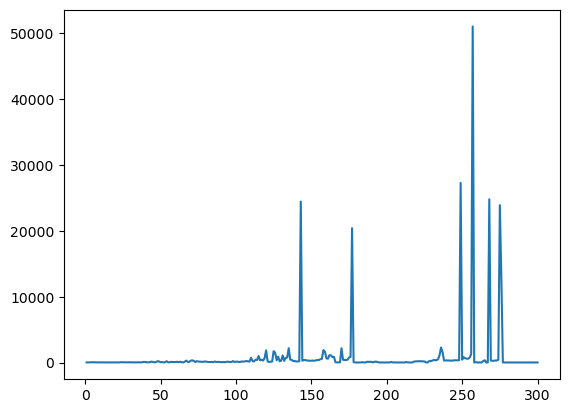

In [12]:
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, input_dims=env.observation_space.shape, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs)

n_games = 300

best_score = -1000
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    (observation, _) = env.reset()
    done = False
    score = 0
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, _, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' % score,'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)
x = [i + 1 for i in range(len(score_history))]
plt.plot(x, score_history)
env.close()

In [13]:
%pip install -e ../.

Obtaining file:///P:/repos/cellitaire-rl
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for cellitaire (pyproject.toml): started
  Building editable for cellitaire (pyproject.toml): finished with status 'done'
  Created wheel for cellitaire: filename=cellitaire-0.0.1-0.editable-py3-none-any.whl size=1307 sha256=0f3d0ed983d5a31799db7ce30da6a5d426248ab96dfc4198ff1944b10e47d2ef
  Stored in directory: C:\Users\Noe\AppData\Local\Temp\pip-ephem-wheel-cache-wiwu6aol\wheels\76\88\96\576254946bf13aa1d012dfa539e7e5e1fddd6ac7e334da0df2


In [3]:
%pip install gymnasium[classic-control]

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [86 lines of output]
  
  
  WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
  Using WINDOWS configuration...
  
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
      exec(compile('''
      ~~~~^^^^^^^^^^^^
      # This is <pip-setuptools-caller> -- a caller that pip uses to run setup.py
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ...<31 lines>...
      exec(compile(setup_py_code, filename, "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      ''' % ('C:\\Users\\Noe\\AppData\\Local\\Temp\\pip-install-eoyw7vpr\\pygame_967dc80c3fe74667b8820019c1335dad\\setup.py',), "<pip-setuptools-caller>", "exec"))
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "<


  Using cached pygame-2.1.3.tar.gz (12.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


In [4]:
%pip install pygame

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------- ----------- 7.6/10.6 MB 42.4 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 37.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
